# **Classification des fromages**

## Clone de la base de données

In [1]:
# Pour l'utilisation sur Google Colab

# !git clone https://github.com/PoirierRomain/Projet-Apprentissage-Profond.git
# %cd /content/Projet-Apprentissage-Profond
# !git pull
# %cd ..

### Bibliothèques

In [2]:
import matplotlib.pyplot as plt
import os
import PIL
from PIL import Image
import numpy as np
import tensorflow
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

2026-02-02 19:24:44.690524: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 19:24:44.772368: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-02 19:24:45.232415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-02 19:24:45.232571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-02 19:24:45.321211: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
def loadSetImages(cheese,pred, set, pathbdd, flag, heigth, width):
    '''
    La fonction getSetImages récupère les images d'un ensemble spécifié d'un type de cheese
    à partir d'un chemin donné et les stocke dans un dictionnaire où la clé est le numéro d'ordre
    de l'image et la valeur est l'image elle-même.

    Args:
        - cheese (str) : Le type de cheese dont vous souhaitez récupérer les images.
        - set (str) : Le nom de l'ensemble d'images à récupérer.
        - pathbdd (str) : Le chemin du répertoire où se trouvent les images.

    Returns:
        - dict : Un dictionnaire contenant les images récupérées, où la clé est un numéro d'ordre
        de l'image et la valeur est l'image elle-même.
    '''


    # Path où se situe les images du set
    pathImages = pathbdd + cheese + "/" + set + "/"

    # Création d'un dictionnaire vide
    images_dict = {}

    # Initialisation d'un compteur
    counter = 1

    # Récupération de la liste des fichiers dans pathbdd
    images = os.listdir(pathImages)

    # Pour chaque fichier
    for imageName in images:
      try:

          if imageName == ".DS_Store" or imageName == ".ipynb_checkpoints":
              continue
          # read l'image
          image = Image.open(pathImages + imageName)
          image = image.convert('RGB')
          # Redimensionnement de l'image
          if flag :
              image = image.resize((width,heigth), Image.BILINEAR)
          # Remplissage de la variable x
          x = np.asarray(image)

          # Ajouter l'image dans le dictionnaire avec pour nom le compteur
          images_dict[counter] = [x, pred]

          # Incrémentation du compteur
          counter += 1
      except:
          None

    # retourner le dictionnaire
    return images_dict

def loadSetImage(set, pathbdd,flag, heigth, width):
    '''
        Récupère les images de différents ensembles pour un type de set spécifié à partir d'un chemin donné
        et les stocke dans un dictionnaire de dictionnaires.

    Args:
        set (str): Le type de set dont on souhaites récupérer les images.
        pathbdd (str): Le chemin du répertoire où se trouvent les images.

    Returns:
        dict: Un dictionnaire de dictionnaires contenant les images récupérées pour chaque ensemble,
        où la clé principale est le nom de l'ensemble et la valeur est un dictionnaire d'images.

    '''
    cheeses = ["beaufort","bleu","brie","camembert","comte","morbier","roquefort","tomme_de_savoie"]
    pred = [1,2,3,4,5,6,7,8]

    # Création d'un dictionnaire vide
    set_images = {}

    i = 0

    # Pour chaque set
    for cheese in cheeses:
        # Récupérer le dictionnaire du set
        set_dict = loadSetImages(cheese,i, set, pathbdd,flag, heigth, width)

        # Associer au dictionnaire vide la clé : set_name et la valeur : set_dict
        set_images[cheese] = set_dict

        i = i + 1

    # retourner le dictionnaire
    return set_images

def loadbdd(pathbdd,flag, heigth, width):
    '''
        Charge les données d'images pour différents types de fromages à partir
        d'un répertoire donné et les stocke dans un dictionnaire.

    Args:
        pathbdd (str): Le chemin du répertoire où se trouvent les données
        d'images pour différents types de fromages.

    Returns:
        MyDict : Le dictionnaire correspondant à la base de donnée.
    '''

    sets = ["train", "test", "validation"]

    # Création d'un dictionnaire vide
    MyDict = {}

    # Pour chaque set
    for set in sets:
        # Récupérer le dictionnaire du set

          setDict = loadSetImage(set, pathbdd,flag, heigth, width);
          # Associer au dictionnaire vide la clé : set_name et la valeur : set_dict
          MyDict[set] = setDict

    # retourner le dictionnaire
    return MyDict

In [11]:
N = 256

# A adapter avec la localisation de la bdd
dic = loadbdd(os.path.join(os.path.join(os.getcwd(), ".."), "bdd/"), 1, N, N)

/home/romai/miniconda3/envs/deep_env/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Echantillon de la base de donnée

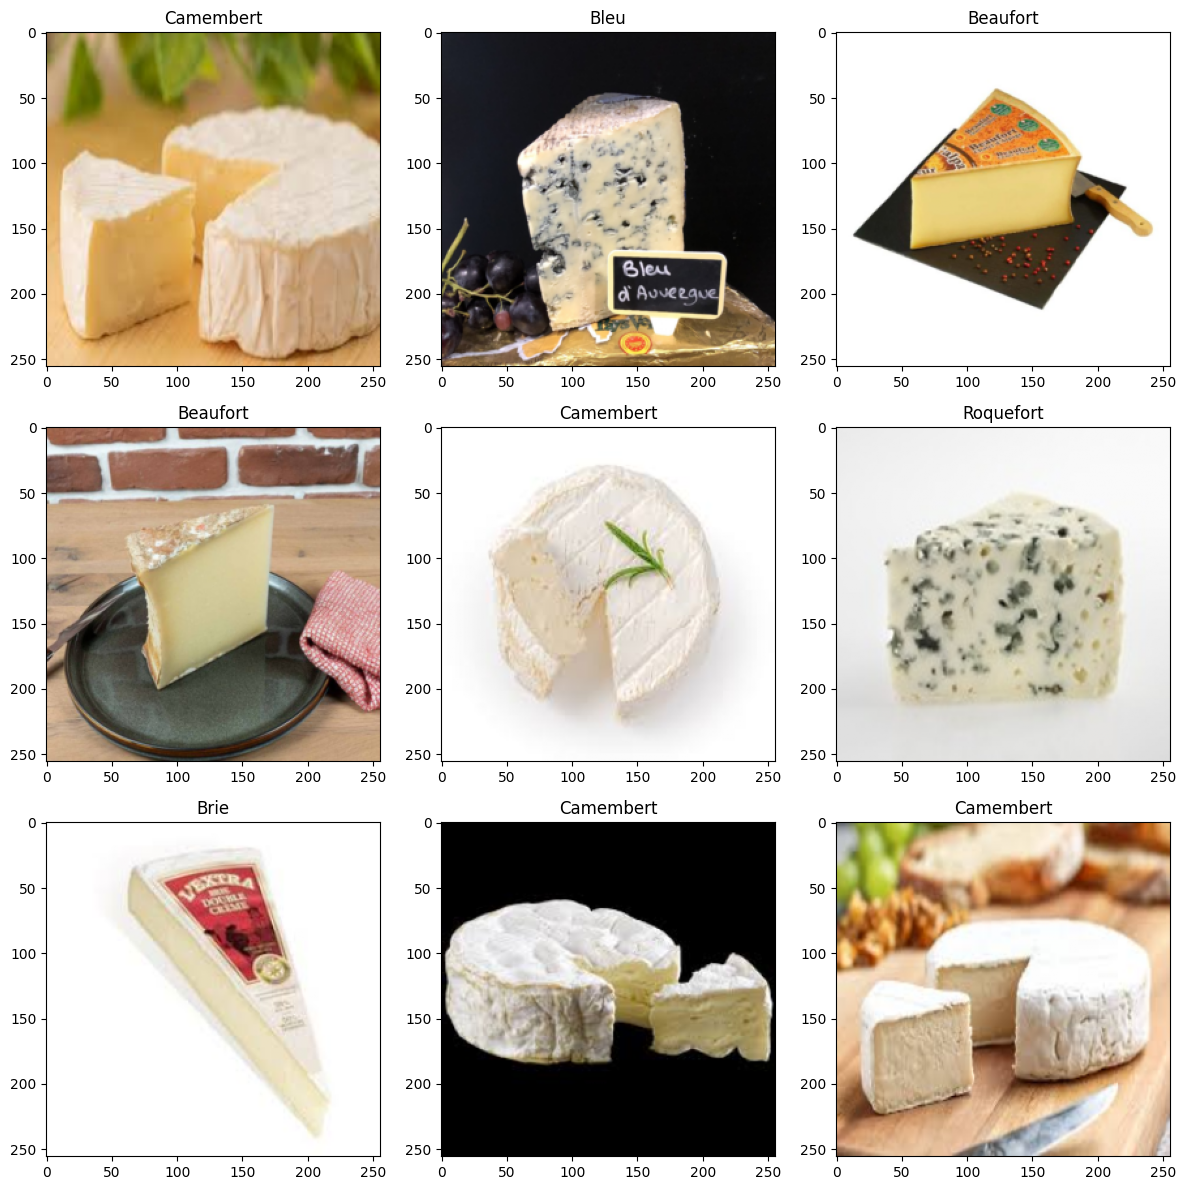

In [13]:
x_train = [v[0] for val in dic["train"].values() for v in val.values()]
y_train = [v[1] for val in dic["train"].values() for v in val.values()]

x_val = [v[0] for val in dic["validation"].values() for v in val.values()]
y_val = [v[1] for val in dic["validation"].values() for v in val.values()]

x_test = [v[0] for val in dic["test"].values() for v in val.values()]
y_test = [v[1] for val in dic["test"].values() for v in val.values()]

cheeses = ["Beaufort","Bleu","Brie","Camembert","Comte","Morbier","Roquefort","Tomme de savoie"]
plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(len(x_train))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(cheeses[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()


## 1er modèle

In [14]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# a commenter pour n = 64
model.add(Conv2D(160, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense
model.add(Dense(256, activation='relu', input_dim=2))   # Couche dense, à 512 neurones
model.add(Dense(8, activation='softmax', input_dim=512))   # Couche de sortie

2026-02-02 19:28:10.664768: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-02 19:28:10.665850: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
input_shape = (None, N, N, 3)
model.build(input_shape) # `input_shape` is the shape of the input data

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 96)        0

In [16]:
# Définition de l'optimiseur
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

In [17]:
n = N*N*3
# correction des bugs liés aux extensions des images
for k in range(len(x_train)):
  x_train[k] = x_train[k][:n]

In [ ]:
x_train = np.array(x_train).reshape(len(x_train), N, N, 3)
y_train = np.array(y_train)
x_val = np.array(x_val).reshape(len(x_val), N, N, 3)
y_val = np.array(y_val)
x_test = np.array(x_test).reshape(len(x_test), N, N, 3)
y_test = np.array(y_test)

In [19]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=40, batch_size=20, shuffle=True)

Epoch 1/40
64/64 [==============================] - 25s 347ms/step - loss: 4.4057 - accuracy: 0.2094 - val_loss: 1.6345 - val_accuracy: 0.3438
Epoch 2/40
64/64 [==============================] - 22s 342ms/step - loss: 1.5883 - accuracy: 0.3797 - val_loss: 1.7407 - val_accuracy: 0.2750
Epoch 3/40
64/64 [==============================] - 20s 305ms/step - loss: 1.3693 - accuracy: 0.4617 - val_loss: 1.5043 - val_accuracy: 0.4000
Epoch 4/40
64/64 [==============================] - 22s 341ms/step - loss: 1.1403 - accuracy: 0.5523 - val_loss: 1.2924 - val_accuracy: 0.4938
Epoch 5/40
64/64 [==============================] - 18s 277ms/step - loss: 0.9969 - accuracy: 0.6438 - val_loss: 1.6565 - val_accuracy: 0.3938
Epoch 6/40
64/64 [==============================] - 21s 326ms/step - loss: 0.8130 - accuracy: 0.7039 - val_loss: 1.4352 - val_accuracy: 0.5188
Epoch 7/40
64/64 [==============================] - 18s 279ms/step - loss: 0.5604 - accuracy: 0.8031 - val_loss: 1.6769 - val_accuracy: 0.4437

In [20]:
# Sauvegarder le modèle
model.save(os.path.join(os.path.join(os.getcwd(), ".."), "models/baseline.keras"))

# Charger le modèle 
# from tensorflow.keras.models import load_model
# model = load_model(os.path.join(os.path.join(os.getcwd(), ".."), "models/baseline.keras"))

In [21]:
def plot_training_analysis():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

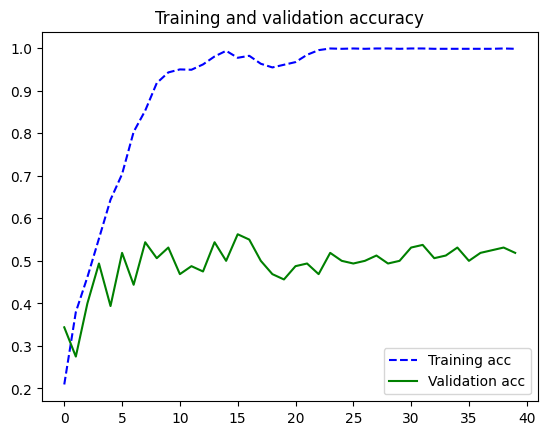

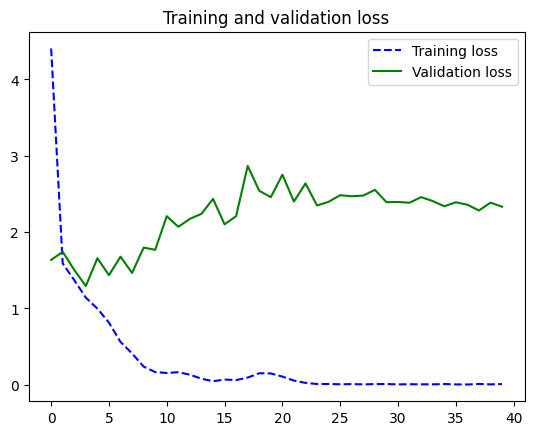

In [22]:
plot_training_analysis()

## Augmentation de données

In [ ]:
# Valeurs à modifier pour améliorer les performances
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    channel_shift_range=20,
    brightness_range=[0.8, 1.2]
    )

# Visualisation des images modifiées
example_x, example_y = train_datagen.flow(x_train, y_train, batch_size=9).next()
plt.figure(figsize=(12, 12))
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    plt.imshow(example_x[i]/255)
plt.tight_layout()
plt.show()


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# a commenter pour n = 64
model.add(Conv2D(160, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(8, activation='softmax', input_dim=512))   # Couche de sortie

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

#Ajout de l'augmentation de donneés
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=30),
                    validation_data=(x_val, y_val),
                    epochs=50,
                    )

In [ ]:
plot_training_analysis()

On observe encore du sur-apprentissage même si il a été réduit.

In [ ]:
# Affichage des features maps associées a chaque conv et max pooling du modèle
def afficher_sortie_filtre(modele, nom_couche, image):
    entree = modele.input
    sortie = modele.get_layer(nom_couche).output
    feature_map_model = Model(inputs=entree, outputs=sortie)

    # Ajouter une dimension de pour le batch à l'image
    image2 = np.expand_dims(image, axis=0)

    feature_map = feature_map_model.predict(image2)

    dim = feature_map.shape[3]
    print(nom_couche + " Taille :" + str(feature_map.shape) + " Dimension :" + str(dim)+"\n")

    fig = plt.figure(figsize=(30, 30))
    nombre_colonnes = dim
    nombre_lignes = 1  # Nombre de lignes fixé à 1 pour afficher les plots en une seule ligne
    for i in range(dim):
        ax = fig.add_subplot(nombre_lignes, nombre_colonnes, i+1)
        ax.axis('off')
        ax.imshow(feature_map[0, :, :, i])

# indice de l'image à afficher
indice_image = 0

# Affichage des résultats pour chaque couche conv2D et maxpooling
for i, layer in enumerate(model.layers):
    if isinstance(layer, Conv2D) or isinstance(layer, MaxPooling2D):
        nom_layers = layer.name
        print("Couche :" + nom_layers)
        afficher_sortie_filtre(model, nom_layers, x_train[indice_image])


## Transfert Learning avec ResNet

In [ ]:
conv_base = ResNet50(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                     include_top=False,
                     input_shape=(N, N, 3))

In [ ]:
conv_base.summary()

In [ ]:
train_features = conv_base.predict(x_train)
# train_features = np.reshape(train_features,(train_features.shape[0],2*2*2048))
train_features = np.reshape(train_features,(train_features.shape[0],8*8*2048))

val_features = conv_base.predict(x_val)
# val_features = np.reshape(val_features,(val_features.shape[0],2*2*2048))
val_features = np.reshape(val_features,(val_features.shape[0],8*8*2048))

In [ ]:
conv_base.trainable = False

model = Sequential()
model.add(conv_base)  # Ajout du modèle entraîné

model.add(Flatten())
model.add(Dense(256, activation='relu', input_dim=8192))   # Couche dense, à 256 neurones de dimension 2 x 2 x 2048
model.add(Dense(8, activation='softmax', input_dim=256))   # Couche de sortie

input_shape = (None, N, N, 3)
model.build(input_shape)

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

#Ajout de l'augmentation de donneés
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=30),
                    validation_data=(x_val, y_val),
                    epochs=50,
                    )

In [ ]:
plot_training_analysis()

## Fine-Tuning

In [ ]:
conv_base.trainable = True
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5), # Taux d'apprentissage réduit pour ne pas tout casser, ni risquer le sur-apprentissage !
              metrics=['accuracy'])

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=30),
                    validation_data=(x_val, y_val),
                    epochs=50,
                    )


In [ ]:
plot_training_analysis()

## Verification sur les données de test

In [ ]:
y_predict = model.predict(x_test)
y_pred = np.argmax(y_predict, axis = 1)

### Matrice de confusion

In [ ]:
def plot_confusion_matrix(cm, normalize=False, cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Matrice de confusion')
    plt.colorbar()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix\n")
    else:
        print('Confusion matrix, without normalization\n')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Classes réelles')
    plt.xlabel('Classes prédites')

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, cmap=plt.cm.Reds)

In [ ]:
# Calcul de la précision
precision = precision_score(y_test, y_pred, average=None)
# Calcul du rappel
recall = recall_score(y_test, y_pred, average=None)
# Calcul du score F1
f1 = f1_score(y_test, y_pred, average=None)

## Calcul a la main pour comparer
def precision(cm, ind):
    # Calcul de la précision pour la classe spécifique
    true_positives = cm[ind, ind]
    total_predicted_positives = cm[:, ind].sum()
    return true_positives / total_predicted_positives

def recall(cm, ind):
    # Calcul du rappel pour la classe spécifique
    true_positives = cm[ind, ind]
    total_actual_positives = cm[ind, :].sum()
    return true_positives / total_actual_positives

def f1_score(cm, ind):
    # Calcul du score F1 pour la classe spécifique
    prec = precision(cm, ind)
    rec = recall(cm, ind)
    return 2 * (prec * rec) / (prec + rec)

ind = 1
prec = precision(cm, ind)
rec = recall(cm, ind)
f1 = f1_score(cm, ind)

print("Précision:", prec)
print("Rappel:", rec)
print("Score F1:", f1)

In [ ]:
precisions = [precision(cm, i) for i in range(8)]
recalls = [recall(cm, i) for i in range(8)]
f1_scores = [f1_score(cm, i) for i in range(8)]

ind_classes = range(1, 9)
cheese_names = [cheeses[i] for i in range(8)]  # Obtenez les noms de fromages correspondants aux indices de classe

plt.figure(figsize=(15, 5))  # Ajustez la taille de la figure pour s'adapter aux trois sous-graphiques

plt.subplot(1, 3, 1)
plt.bar(cheese_names, precisions, color='b')
plt.title('Précision par classe')
plt.xlabel('Fromage')
plt.ylabel('Précision')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour une meilleure lisibilité

plt.subplot(1, 3, 2)
plt.bar(cheese_names, recalls, color='g')
plt.title('Rappel par classe')
plt.xlabel('Fromage')
plt.ylabel('Rappel')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 3)
plt.bar(cheese_names, f1_scores, color='r')
plt.title('Score F1 par classe')
plt.xlabel('Fromage')
plt.ylabel('Score F1')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
precision_mean = np.mean(precisions)
recall_mean = np.mean(recalls)
f1_score_mean = np.mean(f1_scores)

print("Moyenne de précision:", precision_mean)
print("Moyenne de rappel:", recall_mean)
print("Moyenne de score F1:", f1_score_mean)

### Pourcentage de bonne prediction sur les données de test

In [ ]:
def taille(x, y, y_pred):
  sum = 0
  for num_img in range(x.shape[0]):
    id_test = y[num_img]
    id_pred = y_pred[num_img]
    if id_test != id_pred:
      sum += 1
  return sum

def print_data(x, y, y_pred=[]):
  sum = 0
  nombre_lignes = (taille(x, y, y_pred) // 3) + 1
  indices_faux = []

  plt.figure(figsize=(30,30))

  for num_img in range(x.shape[0]):
    img = x[num_img]
    id_test = y[num_img]
    id_pred = y_pred[num_img]

    if id_test != id_pred:
      sum += 1
      indices_faux.append(num_img)

      plt.subplot(nombre_lignes, 3, sum, aspect='equal')
      plt.axis('off')
      # Affichage de l'image
      plt.imshow(img)
      plt.title("Indice : " + str(num_img) + " | Classe : " + cheeses[id_test] + " | Prédiction : " + cheeses[id_pred], fontsize=8)
  plt.show()
  return sum, indices_faux

In [ ]:
nombre_erreur, indices_faux = print_data(x_test, y_test, y_pred)
taux_classification = (len(y_test)-nombre_erreur)/ len(y_test)
print("\nPourcentage de bonne classification : ", round(100*taux_classification,1))

### Faux négatifs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supposons que vous avez déjà la matrice de confusion cm et la liste cheeses

# Calculer les vrais positifs pour chaque fromage (coefficients diagonaux)
true_positives = np.diag(cm)

# Calculer les faux négatifs pour chaque fromage
false_negatives = [sum(cm[i, :]) - cm[i, i] for i in range(len(cheeses))]

# Calculer les faux positifs pour chaque fromage
false_positives = [sum(cm[:, j]) - cm[j, j] for j in range(len(cheeses))]

# Créer une liste d'indices de fromages
indices = list(range(len(cheeses)))

# Largeur des barres dans les histogrammes
bar_width = 0.2

# Créer une figure
plt.figure(figsize=(12, 8))

# Tracer l'histogramme des vrais positifs
plt.bar(np.array(indices) - bar_width, true_positives, width=bar_width, color='blue', label='Vrais positifs')

# Tracer l'histogramme des faux négatifs
plt.bar(indices, false_negatives, width=bar_width, color='red', label='Faux négatifs')

# Tracer l'histogramme des faux positifs
plt.bar(np.array(indices) + bar_width, false_positives, width=bar_width, color='green', label='Faux positifs')

# Ajouter des étiquettes d'axe et une légende
plt.xlabel('Fromages')
plt.ylabel('Nombre')
plt.title('Vrais positifs, faux négatifs et faux positifs par fromage')
plt.xticks(indices, cheeses, rotation='vertical')
plt.legend()

# Afficher la figure
plt.tight_layout()
plt.show()


## Affichage des probabilités de détection pour les classes bien détectées

In [ ]:
def affichage_3_probas(indices, detection):
  predictions = y_predict[indices]
  y_pred = np.argmax(y_predict, axis = 1)

  fig, axes = plt.subplots(3, 3, figsize=(15, 15))

  for i, ax in enumerate(axes.flat):
      # Récupérer les probabilités pour l'image i
      probs = predictions[i]
      # indices des 3 probabilités les plus grandes
      top_indices = np.argsort(probs)[-3:][::-1]
      # Récupérer les 3 plus grandes probabilités
      top_probs = probs[top_indices]

      # Afficher l'image
      ax.imshow(x_test[indices[i]])

      ax.set_xticks([])
      ax.set_yticks([])

      # Formater les probabilités pour les afficher en pourcentage
      formatted_probs = [round(prob * 100, 2) for prob in top_probs]
      # Construire le texte pour le titre avec le bon format
      title_text = '\n'.join(['{}: {} %'.format(cheeses[idx], prob) for idx, prob in zip(top_indices, formatted_probs)])
      if detection:
        ax.set_title('Prediction : {}\n{}'.format(cheeses[y_pred[indices[i]]], title_text))
      else:
        ax.set_title('Prediction : {}, Classe : {}\n{}'.format(cheeses[y_pred[indices[i]]], cheeses[y_test[indices[i]]], title_text))
  plt.tight_layout()
  plt.show()

In [ ]:
n_indices = 9 # Nombre d'images à afficher

# On génère un tableau des indices des fromages qui ont été bien détectés
indices_vrai_n = []
while len(indices_vrai_n) < n_indices:
    index = np.random.randint(len(x_test))
    if index not in indices_faux:
        indices_vrai_n.append(index)

affichage_3_probas(indices_vrai_n, detection=True)

## Affichage des probabilités de détection pour les classes mal détectées

In [ ]:
indices_faux_n = np.random.choice(indices_faux, min(len(indices_faux), n_indices), replace=False)
affichage_3_probas(indices_faux_n, detection=False)